# Lens design example
Ted Corcovilos 2021.09.07

Demonstrating the usefulness of point-transfer-matrices in analyzing lens designs.

The lens here is a photographic Cooke triplet, design adapted from https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

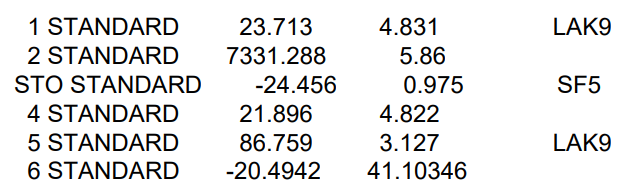

 The first and third elements are LAK9 glass (n=1.69) and the 2nd element is SF5 (n=1.67) (From Schott, λ = 588nm)

Here I'm using standard matrix algebra tools along with ray-transfer and point-transfer matrices as described in my paper.

In [2]:
import numpy as np

First define the ray transfer matrices.  We'll just need the thin lens, translation, and refraction operations for this problem.

In [3]:
def thin_lens(f):
    return np.matrix([[1,0,0],[-1/f,1,0],[0,0,1]])

In [4]:
def translate(d):
    return np.matrix([[1,d,0],[0,1,0],[0,0,1]])

In [5]:
def ref_sph(r,n):
    # r is radius of curvature, r<0 is concave
    # n is relative index of refraction: n_out/n_in
    return np.matrix([[1,0,0],[(1-n)/r/n,1/n,0],[0,0,1]])

In [6]:
# indices of refraction for each element
n1 = n3 = 1.69; n2 = 1.67

Let's break the system into parts to make things simpler.  First, the ray transfer matrix of each element.

In [7]:
E1 = ref_sph(23.71,n1)*translate(4.831)*ref_sph(7331,1/n1)

In [8]:
E2 = ref_sph(-24.46,n2)*translate(0.975)*ref_sph(21.896,1/n2)

In [9]:
E3 = ref_sph(86.76,n3)*translate(3.127)*ref_sph(-20.49,1/n3)

In [10]:
# focal lengths of each element
-1/E1[1,0], -1/E2[1,0], -1/E3[1,0]

(58.234181506686795, -28.39746566867318, 41.43123979988933)

In [11]:
# Break system into two pieces: before and after aperture stop
Mfront = E1*translate(5.86)
Mback = E2*translate(4.822)*E3

In [12]:
# ray transfer matrix of the whole system
Msystem = Mfront*Mback

In [13]:
Msystem

matrix([[ 7.99426521e-01,  3.08543127e+01,  0.00000000e+00],
        [-1.10959011e-02,  8.22644208e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [14]:
#Effective Focal Length
EFL = -1/Msystem[1,0]
EFL

90.12336980481179

In [15]:
# define the adjugate function to calculate the point transfer matrix from the ray tranfer matrix
def adj(M):
    # matrix adjugate (assuming invertible)
    return np.linalg.det(M)*M.I.T

In [16]:
# calculate the point transfer matrix of the whole system
Mpoint = adj(Msystem)
Mpoint

matrix([[ 8.22644208e-01,  1.10959011e-02,  0.00000000e+00],
        [-3.08543127e+01,  7.99426521e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [17]:
# back focal length: image of an infinite object point
BFL=Mpoint*np.matrix([[0],[-1],[0]])
BFL = BFL/BFL[0,0] #normalize
BFL[1,0]

72.04701196475881

In [18]:
# front focal length 
# reverse the system, then find image of an infinite image point
FFL=Mpoint.I*np.matrix([[0],[-1],[0]])
FFL = FFL/FFL[0,0] #normalize
FFL[1,0]

-74.13946818856469

In [19]:
#compare with the formulas in pedrotti
-Msystem[0,0]/Msystem[1,0],Msystem[1,1]/Msystem[1,0]

(72.04701196475881, -74.13946818856468)

If we assume the aperture stop is immediately before the 2nd element and has a radius of 5mm, the pupils may be located by imaging the edge of the AS forward and backward through the system.

The normalized point vectors below have the form (1,_x_,_y_).

In [20]:
# entrance pupil edge
EnP = adj(Mfront.I)*np.matrix([[1],[0],[5]])
EnP = EnP/EnP[0,0] # normalize
EnP

matrix([[ 1.        ],
        [14.02067936],
        [ 4.99772754]])

In [21]:
# exit pupil edge
ExP = adj(Mback)*np.matrix([[1],[0],[5]])
ExP = ExP/ExP[0,0] # normalize
ExP

matrix([[ 1.        ],
        [-8.77585506],
        [ 3.69590147]])

In [22]:
fnumber = EFL/(2*EnP[2,0]) # EFL divided by diameter of entrance pupil
fnumber

9.016434870805467

Let's assume this lens is used with a full-frame 35mm camera.  We can find the field of view by imaging the edge of the sensor back through the system and looking at the outgoing angle.

In [23]:
sensor_edge = np.matrix([[1],[-BFL[1,0]],[35.0/2]])
sensor_edge

matrix([[  1.        ],
        [-72.04701196],
        [ 17.5       ]])

In [24]:
# entrance window edge
EnW=Mpoint.I*sensor_edge
EnW = EnW/EnW[0,0]
EnW

matrix([[  1.        ],
        [-17.77195506],
        [ 10.94534616]])

In [25]:
# field of view, angle measured from center of entrance pupil to edge of entrance window
FOV = 2*np.arctan(EnW[2,0]/(EnW[1,0]-EnP[1,0]))
FOV * 180./np.pi

-37.994406731743645